In [ ]:
import numpy as np
import os
from keras.layers import Dense, Input
from keras.layers import Concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from tensorflow import sin
from tensorflow.keras.backend import set_value

class NeuralDecomposition:

    def __init__(self, data, optimizer='rmsprop',
                 loss='mean_squared_error', units=10,
                 epochs=300, forecast_periods=100,
                 L1_reg=0.01,
                 validation_length=100,
                 batch_size=32):
        """Purpose: initialise class
        data - time series input
        optimizer - keras optimizer
        loss - keras loss
        """

        self.data = data
        self.n_data = len(self.data)
        self.optimizer = optimizer
        self.loss = loss
        self.units = units
        self.epochs = epochs
        self.forecast_periods = forecast_periods
        self.L1_reg = L1_reg
        self.validation_length = validation_length
        self.batch_size = batch_size

    def create_keras_model(self):
        """Purpose: create keras model
        """

        # one dimensional input data
        input_data = Input(shape=(1,), name='input_data')

        # periodical component of the series
        sinusoid = Dense(self.n_data, activation=sin,
                         name='sinusoid')(input_data)

        # g(t) function, components are the same as
        # described in the paper: linear, softplus and sigmoid
        linear = Dense(self.units, activation='linear',
                       name='linear')(input_data)
        softplus = Dense(self.units, activation='softplus',
                         name='softplus')(input_data)
        sigmoid = Dense(self.units, activation='sigmoid',
                        name='sigmoid')(input_data)

        # concatenate layers into one
        one_layer = Concatenate()([sinusoid, linear,
                                   softplus, sigmoid])

        # output layer, add L1 regularizer as in the paper
        output_layer = Dense(1, kernel_regularizer=regularizers.l1(self.L1_reg))(one_layer)

        # compile keras model
        keras_model = Model(inputs=[input_data], outputs=[output_layer])
        keras_model.compile(loss=self.loss, optimizer=self.optimizer)

        # initialize weights
        keras_model = NeuralDecomposition.initialize_weights(
            keras_model, self.n_data, self.units)

        # assign to class
        self.keras_model = keras_model

        return None

    @staticmethod
    def initialize_weights(keras_model, n_data, units):
        """Purpose: initialize weights for compiled
        keras model
        n_data - length of the input data
        units - number of units in the network
        """

        # sanity type checking
        if not isinstance(keras_model, Model):
            raise TypeError('Input must be Keras Model!')

        noise = 0.001
        np.random.seed(42)
        weights = []
        # for details about the weight initialization
        # see the paper
        weights.append((2 * np.pi * np.floor(np.arange(n_data) / 2))[np.newaxis, :].astype('float32')) # sin/kernel
        weights.append((np.pi / 2 + np.arange(n_data) % 2 * np.pi / 2).astype('float32')) # sin/bias

        # initialize weights for g(t)
        for layer in range(2, 8):
            if layer == 2:
                weights.append((np.ones(shape=(1, units)) + np.random.normal(size=(1, units)) * noise).astype('float32')) # linear/kernel
            elif layer in [3, 5, 7]:
                weights.append((np.random.normal(size=(units)) * noise).astype('float32')) # bias
            else:
                weights.append((np.random.normal(size=(1, units)) * noise).astype('float32')) # kernel

        # initialize output layer
        weights.append((np.random.normal(size=(n_data + 3 * units, 1)) * noise).astype('float32')) # output/kernel (n+3)
        weights.append((np.random.normal(size=(1)) * noise).astype('float32')) # output/bias
        # Set weights to the model
        keras_model.set_weights(weights)
        return keras_model

    def train(self):
        """Purpose: train the model obtained in
        create_keras_model() function
        use scaled input data
        """

        if self.n_data == 0:
            raise ValueError("Training data is empty!")

        # create x
        x = np.linspace(0, 1, self.n_data)
        self.x = x

        # create y
        y, self.max_min_list = NeuralDecomposition.scale_data(self.data, self.units)
        # sanity check
        assert len(y) == len(self.data)

        # create validation set, last 100 observations
        x_val = x[-self.validation_length:]
        y_val = y[-self.validation_length:]

        x = x[:-self.validation_length]
        y = y[:-self.validation_length]

        # create model checkpoint
        weights_path = 'nd_weights.keras'  # Updated extension to `.keras`

        model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1,
                                           save_best_only=True, mode='auto')

        callbacks = [model_checkpoint]

        history_model = self.keras_model.fit(
            x, y, epochs=self.epochs, verbose=1,
            batch_size=self.batch_size,
            validation_data=(x_val, y_val),
            callbacks=callbacks)

        self.history_model = history_model

        return None

    def predict(self):
        """Compute predictions, inverse scale the data
        """

        # load weights
        self.keras_model.load_weights('nd_weights.keras')

        # compute predictions
        predictions = self.keras_model.predict(
            np.concatenate([self.x, 1 + np.arange(
                1, self.forecast_periods + 1) * self.x[1]])).flatten()

        # assign to class
        # note, that predictions contain predictions for training
        # set and out-of-sample predictions in the same array
        self.predictions = NeuralDecomposition.inverse_scale_data(
            predictions, self.max_min_list, self.units)

        return self.predictions

    def get_cycles(self):
        """Purpose: get cyclical component of time series
        Intuition: set the relevant weights to zero and compute
        predictions.
        Model equation: data = cycles + trend
        trend is captured by g(t) function
        """

        # Copy the model to avoid modifying the original model's weights
        keras_model_cycles = self.keras_model

        # Set trend g(t) weights to zero
        # Ensure you're correctly indexing and accessing model layers and weights
        for i, layer in enumerate(keras_model_cycles.layers):
            if "dense" in layer.name:  # Check the names to identify layers correctly
                weights = layer.get_weights()
                # Set weights to zero based on the layer type
                if i in [2, 4, 6]:  # Assuming these are the trend layers
                    weights[0] = np.zeros_like(weights[0])
                if i in [3, 5, 7]:  # Bias layers
                    weights[1] = np.zeros_like(weights[1])
                layer.set_weights(weights)

        # Compute cyclical component
        cycles = keras_model_cycles.predict(
            np.concatenate([self.x, 1 + np.arange(
                1, self.forecast_periods + 1) * self.x[1]])).flatten()

        # Assign to class
        self.cycles = NeuralDecomposition.inverse_scale_data(
            cycles, self.max_min_list, self.units)

        return self.cycles

    def get_trend(self):
        """Purpose: get trend component of time series
        It is structured in the same way as get_cycles()
        It is setting weights of cyclical component to zero
        """

        # Copy the model to avoid modifying the original model's weights
        keras_model_trend = self.keras_model

        # Set cyclical component weights to zero
        # Ensure you're correctly indexing and accessing model layers and weights
        for i, layer in enumerate(keras_model_trend.layers):
            if "sinusoid" in layer.name:  # Check the names to identify layers correctly
                weights = layer.get_weights()
                # Set weights to zero for cyclical component
                weights[0] = np.zeros_like(weights[0])
                weights[1] = np.zeros_like(weights[1])
                layer.set_weights(weights)

        # Compute trend component
        trend = keras_model_trend.predict(
            np.concatenate([self.x, 1 + np.arange(
                1, self.forecast_periods + 1) * self.x[1]])).flatten()

        # Assign to class
        self.trend = NeuralDecomposition.inverse_scale_data(
            trend, self.max_min_list, self.units)

        return self.trend

    @staticmethod
    def scale_data(data, units):
        """Purpose: scale data based on
        the number of units
        data - array of data, one dimensional
        units - number of units in the layer
        """
        data = np.array(data)
        if len(data) == 0:
            raise ValueError("Data array is empty, cannot scale.")

        min_value = data.min()
        max_value = data.max()

        # compute scaled output
        scaled_output = (data - min_value) / (max_value - min_value) * units

        return scaled_output, [max_value, min_value]

    @staticmethod
    def inverse_scale_data(data, max_min_list, units):
        """Purpose: inverse the scaled data obtained
        from the scale_data() function
        data - array of data, one dimmensional
        max_min_list - list of max and min values,
        obtained using scale_data() function
        max_min_list = [max_value, min_value]
        """

        # sanity check
        if len(max_min_list) != 2:
            raise TypeError('Input must be list and len == 2!')
        if max_min_list[1] > max_min_list[0]:
            raise ValueError('Check values in the input list!')

        # get min and max values
        max_value = max_min_list[0]
        min_value = max_min_list[1]

        inv_scaled_data = data * (max_value - min_value) / units + min_value

        return inv_scaled_data



In [ ]:
import pandas as pd
testing_set = pd.read_excel('testing_set.xlsx')
# Ensure that the testing and training sets are populated with actual data.

training_set = pd.read_excel('training_set.xlsx')
all_data = pd.read_excel('all_data.xlsx')

nd = NeuralDecomposition(
    epochs=1500,
    forecast_periods=len(testing_set),
    data=training_set,
    L1_reg=0.01,
    units=15,
    batch_size=100,
    validation_length=2)  # Adjust validation length if necessary

nd.create_keras_model()

nd.train()

# predict some periods ahead
predictions = nd.predict()

# this function could be used to extract cycles from
# time series
cycles = nd.get_cycles()

# Extract trends from time series
trend = nd.get_trend()


Streaming output truncated to the last 5000 lines.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2936 - val_loss: 0.8686
Epoch 252/1500
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2963
Epoch 252: val_loss did not improve from 0.57754
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2948 - val_loss: 0.9468
Epoch 253/1500
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2912
Epoch 253: val_loss did not improve from 0.57754
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2920 - val_loss: 0.7556
Epoch 254/1500
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3046
Epoch 254: val_loss did not improve from 0.57754
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2963 - val_loss: 0.8149
Epoch 255/1500
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.3010
Epoch 255: val_loss did not improve from 0.57754
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2959 - val_loss: 1.0137
Epoch 256/1500
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2889
Epoch 256: val_loss did not improve from 0.57754
7/7 ━━━━

In [4]:
print("Predictions:", predictions)
print("Cycles:", cycles)

Predictions: [ 33.445976  32.420162  33.70696   37.639557  36.25133   37.48953
  38.429916  37.701893  37.564014  39.433193  37.89046   39.438164
  39.667866  38.328205  38.312965  37.089798  37.61945   37.779007
  38.56876   37.635468  37.605865  37.581795  37.33773   37.256496
  37.928143  38.35505   39.139404  41.123077  41.074223  41.368996
  42.42803   41.46829   41.84199   43.020714  42.000046  42.020466
  41.705784  40.871845  40.57902   41.090668  40.65798   41.956055
  42.292095  41.970856  42.86388   43.070477  43.43402   43.547028
  44.0418    43.87576   43.372826  43.850517  44.502087  44.202297
  44.163597  45.00387   46.173416  46.298424  46.844025  46.852688
  47.387245  47.006847  47.545345  48.762146  48.604248  49.322266
  49.468246  51.856552  51.64704   54.016445  54.245796  54.558083
  51.256935  52.16295   52.473503  53.353123  52.03428   51.44364
  52.104523  51.125977  51.365593  49.93109   48.953224  51.45862
  52.85225   52.90188   52.826706  53.142673  51.491

In [5]:
# Size of training set
training_size = len(training_set)
print(f"Training Set Size: {training_size}")

# Size of test set
test_size = len(testing_set)
print(f"Test Set Size: {test_size}")

# Size of predictions
predictions_size = len(predictions)
print(f"Predictions Size: {predictions_size}")

data_size = len(all_data)
print(f"data Size: {data_size}")

Training Set Size: 610
Test Set Size: 153
Predictions Size: 763
data Size: 763


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming `predictions` and `test_set` are your prediction and actual values respectively

# Calculate MAE
mae = mean_absolute_error(all_data, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(all_data, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 6.037396911381112
Root Mean Squared Error (RMSE): 13.97668564795162


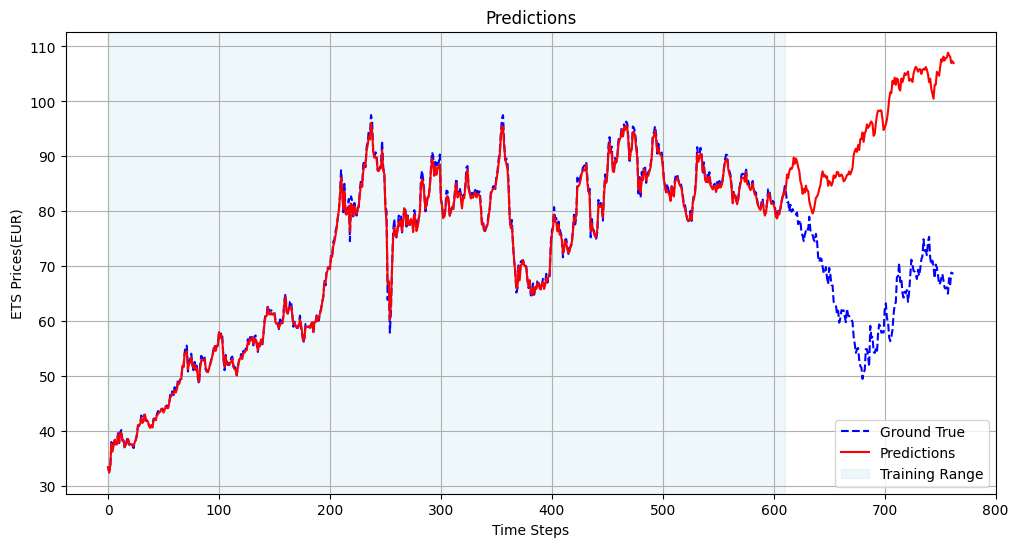

In [14]:
import matplotlib.pyplot as plt

# Assuming `test_set` and `prediction` are numpy arrays or lists

plt.figure(figsize=(12, 6))

# Plot test set
plt.plot(all_data, label='Ground True', color='blue', linestyle='--')

# Plot prediction
plt.plot(predictions, label='Predictions', color='red')
plt.axvspan(0, training_size, color='lightblue', alpha=0.2, label='Training Range')
plt.title('Predictions')
plt.xlabel('Time Steps')
plt.ylabel('ETS Prices(EUR)')
plt.legend()
plt.grid(True)
plt.show()
